# Playground for the models

## Import the data

In [114]:
import os
import pandas as pd

def import_data():
    try:
        path = os.path.join(os.getcwd() + "/data/cleaned_data.csv")
        df = pd.read_csv(path, index_col=0, parse_dates=["date_publication", "date_exp"], infer_datetime_format=True)
        print("Data imported sucessfully.")
        return df
    except Exception as e:
        print("Cannot import data: {e}")
        return None
    
df = import_data()


/Users/bastien/tmp/ipykernel_5099/3940660401.py:7: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(path, index_col=0, parse_dates=["date_publication", "date_exp"], infer_datetime_format=True)


Data imported sucessfully.


## Cleaning the reviews

In [115]:
import re
def clean_text(text):
    try:    
        text = re.sub(r'\n', '', text)  # Replace newlines with a space
        text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with one
        return text
    except Exception as e:
        print("No translation")
        return "No translation"
df["avis_en"] = df["avis_en"].apply(clean_text)
# Removing rows without translation
df = df[df['avis_en'] != 'No translation']

No translation
No translation


## Filter only training data

In [116]:
def keep_labeled_ratings():
    try:
        df_copy = df[df["type"] == "train"].copy()
        df_copy.drop("type", axis=1, inplace=True)
        print("Data filtered sucessfully.")
        return df_copy
    except Exception as e:
        print(f"Cannot filter the dataset : {e}")
        return None


df = keep_labeled_ratings()


Data filtered sucessfully.


## Balance the outputs

In [117]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
def balance_classes():
    try:
        # Separate features and target variable
        X = df.drop("note", axis=1)  # Features
        y = df["note"]  # Target variable
        
        # Check class distribution before balancing
        print("Class distribution before balancing:", Counter(y))

        # Undersample the majority class
        undersample = RandomUnderSampler(sampling_strategy='auto', random_state=42)
        X_res, y_res = undersample.fit_resample(X, y)

        # Check class distribution after balancing
        print("Class distribution after balancing:", Counter(y_res))
        
        # Reconstruct the balanced DataFrame
        df_balanced = pd.DataFrame(X_res, columns=X.columns)
        df_balanced["note"] = y_res
        
        print("Classes balanced successfully.")
        return df_balanced
    except Exception as e:
        print("Could not balance classes")
        return None



# Assuming 'df' is your DataFrame and 'rating' is your target column
df = balance_classes()

Class distribution before balancing: Counter({1.0: 7271, 4.0: 4885, 5.0: 4849, 2.0: 3716, 3.0: 3382})
Class distribution after balancing: Counter({1.0: 3382, 2.0: 3382, 3.0: 3382, 4.0: 3382, 5.0: 3382})
Classes balanced successfully.


In [118]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorizing the cleaned text
vectorizer = TfidfVectorizer(max_features=5000)  # Limiting to top 5000 features
X = vectorizer.fit_transform(df["avis_en"]).toarray()

# Target variable (ratings)
y = df["note"]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Logistic regression & Random forest

In [119]:

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

def train_and_evaluate(model, X_train, y_train, X_test, y_test):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluation metrics
    acc = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    return acc, class_report, conf_matrix

# Evaluation
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

from sklearn.metrics import confusion_matrix, accuracy_score

# Evaluate Logistic Regression
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)
print("Accuracy for Logistic Regression:", accuracy_score(y_test, y_pred_lr))

# Evaluate Random Forest
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
print("Accuracy for Random Forest:", accuracy_score(y_test, y_pred_rf))



Logistic Regression Classification Report:
              precision    recall  f1-score   support

         1.0       0.50      0.62      0.55       656
         2.0       0.45      0.43      0.44       696
         3.0       0.38      0.33      0.35       716
         4.0       0.39      0.33      0.36       664
         5.0       0.53      0.61      0.57       650

    accuracy                           0.46      3382
   macro avg       0.45      0.46      0.45      3382
weighted avg       0.45      0.46      0.45      3382

Random Forest Classification Report:
              precision    recall  f1-score   support

         1.0       0.44      0.63      0.52       656
         2.0       0.39      0.34      0.36       696
         3.0       0.38      0.26      0.30       716
         4.0       0.40      0.34      0.37       664
         5.0       0.49      0.61      0.54       650

    accuracy                           0.43      3382
   macro avg       0.42      0.43      0.42      33

### Confusion matrices

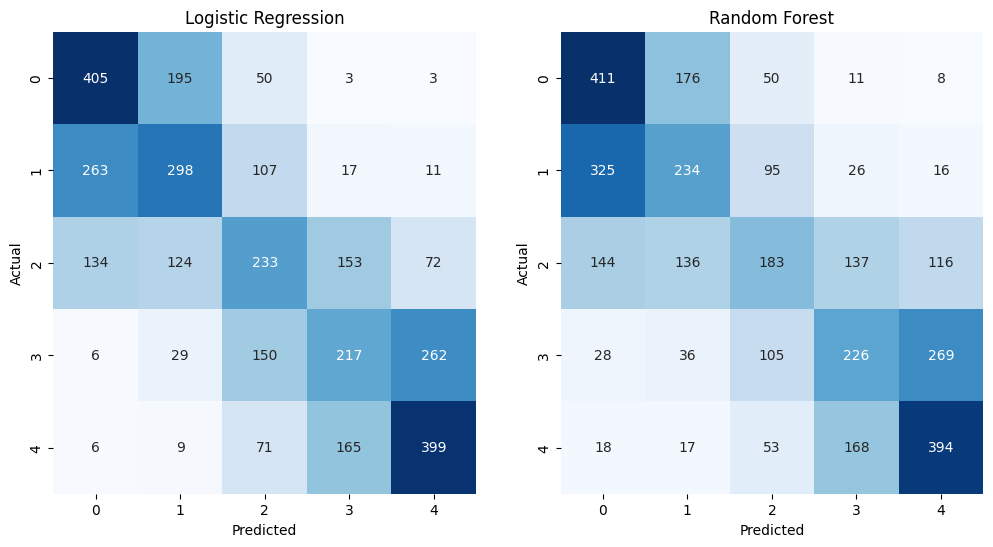

In [120]:

import matplotlib.pyplot as plt
import seaborn as sns

# Create a matplotlib figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot confusion matrix for Logistic Regression
sns.heatmap(conf_matrix_lr, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[0])
axes[0].set_title("Logistic Regression")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# Plot confusion matrix for Random Forest
sns.heatmap(conf_matrix_rf, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[1])
axes[1].set_title("Random Forest")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

# Show the plot
plt.savefig("media/modelPerformance.png")

### Class predicted density

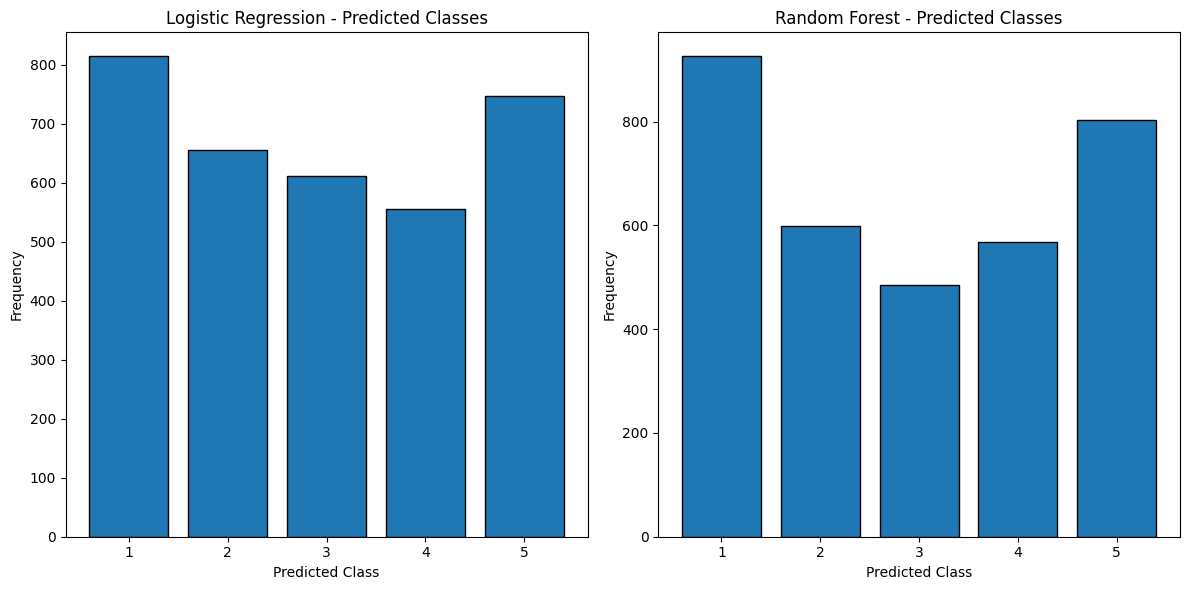

In [121]:

# Create a matplotlib figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot distribution of predicted classes for Logistic Regression
axes[0].hist(y_pred_lr, bins=range(1, 7), edgecolor='black', align='left', rwidth=0.8)
axes[0].set_title("Logistic Regression - Predicted Classes")
axes[0].set_xlabel("Predicted Class")
axes[0].set_ylabel("Frequency")

# Plot distribution of predicted classes for Random Forest
axes[1].hist(y_pred_rf, bins=range(1, 7), edgecolor='black', align='left', rwidth=0.8)
axes[1].set_title("Random Forest - Predicted Classes")
axes[1].set_xlabel("Predicted Class")
axes[1].set_ylabel("Frequency")

# Show the plot
plt.tight_layout()
plt.show()

In [122]:
import pandas as pd
from transformers import pipeline
from tqdm import tqdm  # Import tqdm

# Initialize the classifier
classifier = pipeline(task="text-classification", model="SamLowe/roberta-base-go_emotions", top_k=None)

# List to accumulate filtered results for the DataFrame
all_filtered_results = []

# Get the sentences from the 'avis_en' column and corresponding 'note' column of the 'train' DataFrame
sentences = df["avis_en"]
notes = df["note"]

# Specify the labels you want to keep as columns
labels_to_keep = ['disappointment', 'neutral', 'anger', 'joy', 'surprise']

# Loop through the sentences with tqdm to show the progress bar
for sentence in tqdm(sentences, desc="Processing Sentences", unit="sentence"):
    # Get model outputs with truncation and max_length parameters
    model_outputs = classifier([sentence], truncation=True, max_length=512)

    result_dict = {}
    # Filter the results and store only the scores for the selected labels
    for item in model_outputs[0]:
        if item['label'] in labels_to_keep:
            result_dict[item['label']] = item['score']

    # If a label does not appear in the output, add it with a score of 0
    for label in labels_to_keep:
        if label not in result_dict:
            result_dict[label] = 0.0
    # Append the result for this sentence to the list
    all_filtered_results.append(result_dict)

# Convert the accumulated results to a DataFrame
df_result = pd.DataFrame(all_filtered_results)

# Print the DataFrame
print(df_result)

Device set to use mps:0
Processing Sentences: 100%|██████████| 16910/16910 [09:20<00:00, 30.17sentence/s] 

        neutral  disappointment     anger       joy  surprise
0      0.330693        0.018527  0.009120  0.001209  0.000722
1      0.146605        0.843846  0.004996  0.003336  0.007165
2      0.252050        0.079211  0.004408  0.003101  0.001426
3      0.292341        0.014972  0.002316  0.001202  0.001026
4      0.590386        0.020891  0.010447  0.001126  0.003069
...         ...             ...       ...       ...       ...
16905  0.060782        0.001384  0.000722  0.014169  0.000803
16906  0.042102        0.004305  0.002347  0.047329  0.009841
16907  0.117031        0.003100  0.001175  0.013991  0.002142
16908  0.049982        0.003047  0.001722  0.016964  0.000649
16909  0.074546        0.002058  0.001076  0.627283  0.005467

[16910 rows x 5 columns]


In [123]:
from sklearn.preprocessing import MinMaxScaler

# Initialize Min-Max Scaler
scaler = MinMaxScaler()

# Fit and transform the training data
df_scaled = scaler.fit_transform(df_result[['disappointment', 'neutral', 'anger', 'joy', 'surprise']])


In [124]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_scaled,notes, test_size=0.2, random_state=42)

In [125]:

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# Random Forest
model = RandomForestClassifier(max_depth = 10, max_features = 'sqrt',min_samples_leaf= 4,min_samples_split= 10, n_estimators= 300)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Evaluation
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

from sklearn.metrics import confusion_matrix, accuracy_score

# Evaluate Logistic Regression
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)
print("Accuracy for Logistic Regression:", accuracy_score(y_test, y_pred_lr))
print("Confusion Matrix for Logistic Regression:")
print(conf_matrix_lr)

# Evaluate Random Forest
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
print("Accuracy for Random Forest:", accuracy_score(y_test, y_pred_rf))
print("Confusion Matrix for Random Forest:")
print(conf_matrix_rf)



Logistic Regression Classification Report:
              precision    recall  f1-score   support

         1.0       0.34      0.69      0.46       656
         2.0       0.35      0.03      0.05       696
         3.0       0.26      0.12      0.17       716
         4.0       0.21      0.10      0.13       664
         5.0       0.38      0.78      0.51       650

    accuracy                           0.34      3382
   macro avg       0.31      0.34      0.26      3382
weighted avg       0.31      0.34      0.26      3382

Random Forest Classification Report:
              precision    recall  f1-score   support

         1.0       0.38      0.46      0.42       656
         2.0       0.35      0.34      0.34       696
         3.0       0.27      0.18      0.22       716
         4.0       0.35      0.34      0.34       664
         5.0       0.42      0.49      0.45       650

    accuracy                           0.36      3382
   macro avg       0.35      0.36      0.35      33

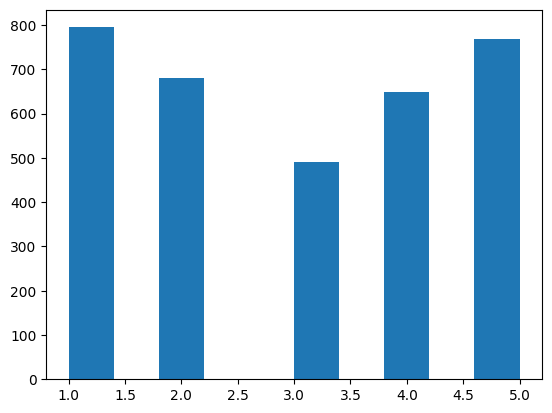

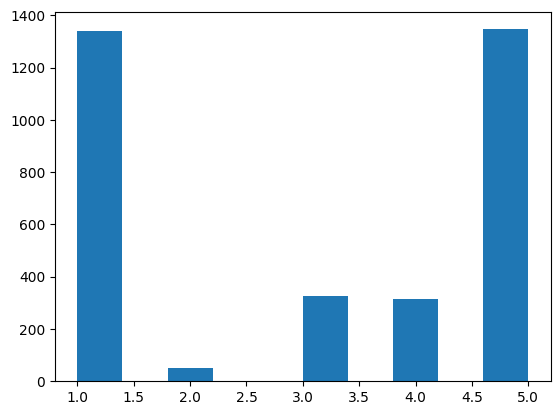

In [126]:
plt.hist(y_pred_rf)
plt.show()
plt.hist(y_pred_lr)
plt.show()

In [127]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# Initialize the Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=42,class_weight='balanced')

# Define the parameter grid
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10],
    'max_features': [None, 'sqrt', 'log2'],
    'class_weight': [None, 'balanced']
}

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, 
                           scoring='accuracy', cv=5, verbose=2, n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters and estimator
print("Best Parameters:", grid_search.best_params_)
best_dt = grid_search.best_estimator_

# Evaluate the model
y_pred = best_dt.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END class_weight=None, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END class_weight=None, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END class_weight=None, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END class_weight=None, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END class_weight=None, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END class_weight=None, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END class_weight=None, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END class_weight=None, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_spli

(array([607.,   0., 918.,   0.,   0., 414.,   0., 790.,   0., 653.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

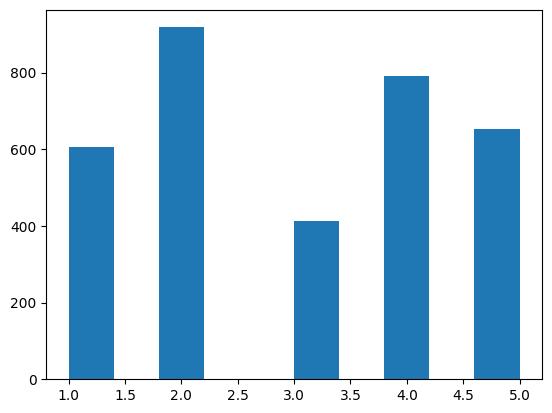

In [128]:
plt.hist(y_pred)

In [129]:
from sklearn.svm import SVC

# Initialize and fit Support Vector Classifier
svm = SVC(random_state=42)
svm.fit(X_train, y_train)

SVC(random_state=42)

In [130]:

y_pred_svm = svm.predict(X_test)

# Evaluation
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

# Evaluate SVM
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
print("Accuracy for SVM:", accuracy_score(y_test, y_pred_svm))
print("Confusion Matrix for SVM:")
print(conf_matrix_svm)


SVM Classification Report:
              precision    recall  f1-score   support

         1.0       0.32      0.63      0.42       656
         2.0       0.38      0.18      0.25       696
         3.0       0.25      0.06      0.10       716
         4.0       0.28      0.19      0.23       664
         5.0       0.40      0.69      0.50       650

    accuracy                           0.34      3382
   macro avg       0.33      0.35      0.30      3382
weighted avg       0.32      0.34      0.30      3382

Accuracy for SVM: 0.34210526315789475
Confusion Matrix for SVM:
[[412 132  36  50  26]
 [420 127  40  69  40]
 [279  58  45 105 229]
 [105  13  31 126 389]
 [ 71   4  27 101 447]]


In [131]:
df_scaled

array([[2.06769575e-02, 3.37948773e-01, 1.07335556e-02, 9.80428251e-04,
        6.37530729e-04],
       [9.67191179e-01, 1.48220390e-01, 5.73291536e-03, 3.33852272e-03,
        8.09971179e-03],
       [9.02717718e-02, 2.56896010e-01, 5.02079389e-03, 3.07780299e-03,
        1.45293985e-03],
       ...,
       [2.98398276e-03, 1.17740453e-01, 1.10130234e-03, 1.51475541e-02,
        2.28251655e-03],
       [2.92295242e-03, 4.86367207e-02, 1.76365888e-03, 1.84432148e-02,
        5.52744533e-04],
       [1.78922534e-03, 7.39538724e-02, 9.81214259e-04, 6.94883622e-01,
        6.13278913e-03]])

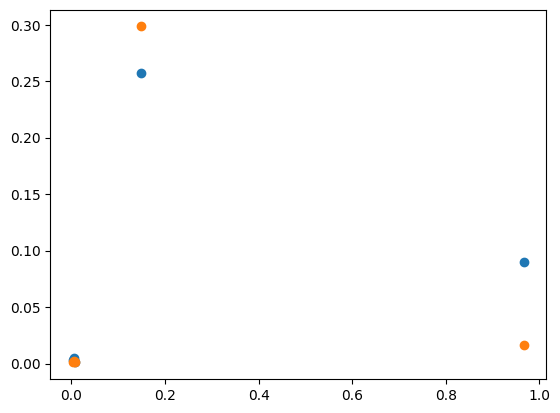

In [132]:
plt.scatter(df_scaled[1], df_scaled[2])
plt.scatter(df_scaled[1], df_scaled[3])


In [133]:
import pickle

# Assuming your two models are `model1` and `model2`
models = {'model1': classifier, 'model2': rf_model}

# Save the models using pickle
with open("models/huggingface_randomforest_model.pkl", "wb") as f:
    pickle.dump(models, f)

In [134]:
import os


import openai

# Ensure that the OpenAI API key is accessible
openai.api_key = os.getenv("OPENAI_API_KEY")


In [137]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

model_name = "tabularisai/multilingual-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

def predict_sentiment(texts):
    inputs = tokenizer(texts, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
    sentiment_map = {0: "Very Negative", 1: "Negative", 2: "Neutral", 3: "Positive", 4: "Very Positive"}
    return [sentiment_map[p] for p in torch.argmax(probabilities, dim=-1).tolist()]

texts = df["avis_en"].to_list()

notes = df["note"]
sentiment_rating_map = {"Very Negative": 1.0, "Negative": 2.0, "Neutral": 3.0, "Positive": 4.0,  "Very Positive": 5.0}
all_filtered_results = []
for text in tqdm(texts, desc="Processing Sentences", unit="sentence"):
    feeling = {"predicted_feeling" : predict_sentiment(text)[0]}
    rating_dict = {"predicted_rating" : sentiment_rating_map[feeling["predicted_feeling"]]}

    all_filtered_results.append(rating_dict)

# Convert the accumulated results to a DataFrame
df_result = pd.DataFrame(all_filtered_results)

# Print the DataFrame
print(df_result)

Processing Sentences: 100%|██████████| 16910/16910 [06:13<00:00, 45.27sentence/s]

       predicted_rating
0                   1.0
1                   2.0
2                   1.0
3                   1.0
4                   2.0
...                 ...
16905               4.0
16906               3.0
16907               5.0
16908               5.0
16909               5.0

[16910 rows x 1 columns]


In [138]:
# Evaluate SVM
conf_matrix = confusion_matrix(notes, df_result)
print("Accuracy for SVM:", accuracy_score(notes, df_result))
print("Confusion Matrix for SVM:")
print(conf_matrix)

Accuracy for SVM: 0.3810762862211709
Confusion Matrix for SVM:
[[1759  627  519  110  367]
 [1443  719  715  164  341]
 [ 623  482  900  939  438]
 [  69  113  670 1700  830]
 [  47   33  287 1649 1366]]


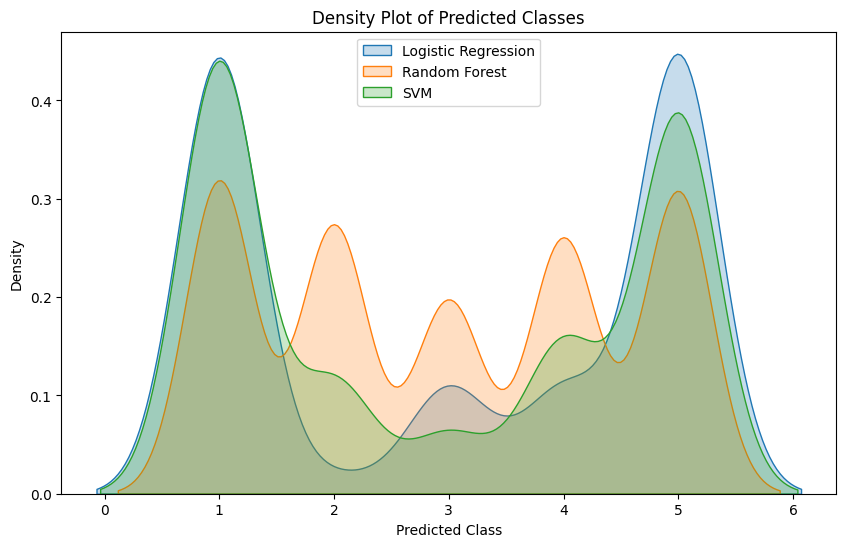

In [140]:
import seaborn as sns

import matplotlib.pyplot as plt

# Create a matplotlib figure
plt.figure(figsize=(10, 6))

# Plot density for Logistic Regression predicted classes
sns.kdeplot(y_pred_lr, label='Logistic Regression', fill=True)

# Plot density for Random Forest predicted classes
sns.kdeplot(y_pred_rf, label='Random Forest', fill=True)

# Plot density for SVM predicted classes
sns.kdeplot(y_pred_svm, label='SVM', fill=True)

# Add title and labels
plt.title('Density Plot of Predicted Classes')
plt.xlabel('Predicted Class')
plt.ylabel('Density')
plt.legend()

# Show the plot
plt.show()